In [2]:
import pandas as pd
import tensorflow as tf
import yfinance as yf
import numpy as np
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input,GlobalAveragePooling1D
from keras import optimizers
import matplotlib.pyplot as plt
import keras_tuner as kt
from datetime import datetime, timedelta
import math

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
policy = keras.mixed_precision.Policy('mixed_float16')
keras.mixed_precision.set_global_policy(policy)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16255004444577833389
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5729419264
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3916922587709835917
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


In [4]:
timestep = 100
testfrac = 0.25
valfrac = 0.2

In [5]:
start_date = '2010-01-01'
today = datetime.now()
end_date = datetime.strftime(today, '%Y-%m-%d')
display(end_date)
data = yf.download("AAPL", start=start_date, end=end_date) #Displays till yesterday as today is not complete
data = data.reset_index()
dataclose = data['Adj Close']

'2024-01-19'

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Adj Close,Volume
0,7.622500,7.660714,7.585000,6.478997,493729600
1,7.664286,7.699643,7.616071,6.490199,601904800
2,7.656429,7.686786,7.526786,6.386964,552160000
3,7.562500,7.571429,7.466071,6.375158,477131200
4,7.510714,7.571429,7.466429,6.417540,447610800
...,...,...,...,...,...
3529,186.539993,187.050003,183.619995,185.589996,49128400
3530,186.059998,186.740005,185.190002,185.919998,40444700
3531,182.160004,184.259995,180.929993,183.630005,65603000
3532,181.270004,182.929993,180.300003,182.679993,47317400


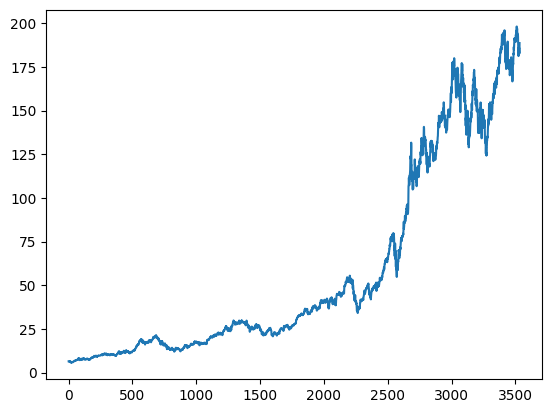

In [6]:
data = data[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
display(data)
plt.plot(dataclose)
plt.show()

In [7]:
Xscaler = MinMaxScaler()
Xdata = Xscaler.fit_transform(np.array(data))
Yscaler = MinMaxScaler()
Ydata = Yscaler.fit_transform(np.array([data['Adj Close']]).transpose()).reshape((Xdata.shape[0],))
display(Xdata.shape)
display(Ydata.shape)

(3534, 5)

(3534,)

In [8]:
X_temp, X_test = train_test_split(Xdata, test_size=testfrac, shuffle=False)
Y_temp, Y_test = train_test_split(Ydata, test_size=testfrac, shuffle=False)
X_train, X_val = train_test_split(X_temp, test_size=valfrac, shuffle=False)
Y_train, Y_val = train_test_split(Y_temp, test_size=valfrac, shuffle=False)


In [9]:
def build_timeseries(Xdata, Ydata, time_step):
    dim_0 = Xdata.shape[0] - time_step
    dim_1 = Xdata.shape[1]

    x = np.zeros((dim_0, time_step, dim_1))
    y = np.zeros((Ydata.shape[0] - time_step,))

    for i in range(dim_0):
        x[i] = Xdata[i:time_step+i]
        y[i] = Ydata[time_step+i]
    return x, y

In [10]:
X_train, Y_train = build_timeseries(X_train, Y_train, timestep)
X_test, Y_test = build_timeseries(X_test, Y_test, timestep)
X_val, Y_val = build_timeseries(X_val, Y_val, timestep)
print("X Train Shape: ", X_train.shape, "   Y Train Shape: ", Y_train.shape)
print("X Val Shape: ", X_val.shape, "   Y Val Shape: ", Y_val.shape)
print("X Test Shape: ", X_test.shape, "   Y Test Shape: ", Y_test.shape)

X Train Shape:  (2020, 100, 5)    Y Train Shape:  (2020,)
X Val Shape:  (430, 100, 5)    Y Val Shape:  (430,)
X Test Shape:  (784, 100, 5)    Y Test Shape:  (784,)


In [11]:
display(X_train.shape)
display(X_val.shape)
display(X_test.shape)

(2020, 100, 5)

(430, 100, 5)

(784, 100, 5)

In [12]:
def model_builder(hp):
    lstm_model = Sequential()
    
    lstm_units_0 = hp.Int('units_lstm_0', min_value=128, max_value=256, step=16)
    lstm_units_1 = hp.Int('units_lstm_1', min_value=16, max_value=256, step=16)
    lstm_units_2 = hp.Int('units_lstm_2', min_value=16, max_value=256, step=16)
    dense_units_0 = hp.Int('units_dense_0', min_value=16, max_value=128, step=16)
    dense_units_1 = hp.Int('units_dense_1', min_value=16, max_value=128, step=16)
    dense_units_2 = hp.Int('units_dense_2', min_value=16, max_value=128, step=16)
    lstm_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    lstm_model.add(LSTM(units=lstm_units_0, return_sequences=True))
    lstm_model.add(LSTM(units=lstm_units_1, return_sequences=True))
    lstm_model.add(LSTM(units=lstm_units_2, return_sequences=True))
    lstm_model.add(GlobalAveragePooling1D())
    lstm_model.add(Dense(units=dense_units_0,activation='relu'))
    lstm_model.add(Dense(units=dense_units_1,activation='relu'))
    lstm_model.add(Dropout(0.05))
    lstm_model.add(Dense(units=dense_units_2, activation='linear'))
    lstm_model.add(Dense(units=1))
    lstm_model.summary()
    
    hyperparameters_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.05, 0.1])
    
    lstm_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=hyperparameters_learning_rate))
    
    return lstm_model

In [26]:
tuner = kt.BayesianOptimization(
    model_builder,
    objective='val_loss',
    max_trials=100)
tuner.search(X_train, Y_train, epochs=100, validation_data=(X_val,Y_val))
lstm_model  = tuner.get_best_models()[0]  
print(lstm_model.summary())
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

Reloading Tuner from .\untitled_project\tuner0.json
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 144)          86400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 144)          166464    
                                                                 
 lstm_2 (LSTM)               (None, 100, 160)          195200    
                                                                 
 global_average_pooling1d (G  (None, 160)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 96)                15456     
                                                                 
 dense_1 (Dense)             (None, 48)                4656      
    

In [27]:
lstm_model.save("AAPL_LSTM.keras")

In [28]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 144)          86400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 144)          166464    
                                                                 
 lstm_2 (LSTM)               (None, 100, 160)          195200    
                                                                 
 global_average_pooling1d (G  (None, 160)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 96)                15456     
                                                                 
 dense_1 (Dense)             (None, 48)                4656      
                                                        

In [29]:
lstm_model.fit(X_train,Y_train,validation_data = (X_val,Y_val),epochs = 100,batch_size = 64,verbose = 1)

Epoch 1/100
32/32 [==============================] - 5s 54ms/step - loss: 1.2713e-04 - val_loss: 0.0028
Epoch 2/100
32/32 [==============================] - 1s 28ms/step - loss: 9.4303e-05 - val_loss: 0.0013
Epoch 3/100
32/32 [==============================] - 1s 28ms/step - loss: 7.9997e-05 - val_loss: 0.0014
Epoch 4/100
32/32 [==============================] - 1s 31ms/step - loss: 8.0079e-05 - val_loss: 0.0021
Epoch 5/100
32/32 [==============================] - 1s 32ms/step - loss: 6.9718e-05 - val_loss: 0.0013
Epoch 6/100
32/32 [==============================] - 1s 29ms/step - loss: 7.2469e-05 - val_loss: 0.0496
Epoch 7/100
32/32 [==============================] - 1s 30ms/step - loss: 6.9781e-05 - val_loss: 0.0017
Epoch 8/100
32/32 [==============================] - 1s 32ms/step - loss: 7.8760e-05 - val_loss: 0.0012
Epoch 9/100
32/32 [==============================] - 1s 33ms/step - loss: 8.9715e-05 - val_loss: 0.0015
Epoch 10/100
32/32 [==============================] - 1s 32ms/st

In [30]:
train_predict = lstm_model.predict(X_train)
val_predict = lstm_model.predict(X_val)
test_predict = lstm_model.predict(X_test)
train_predictraw = Yscaler.inverse_transform(train_predict).reshape((train_predict.shape[0],))
val_predictraw = Yscaler.inverse_transform(val_predict).reshape((val_predict.shape[0],))
test_predictraw = Yscaler.inverse_transform(test_predict).reshape((test_predict.shape[0],))

25/25 [==============================] - 0s 10ms/step


In [31]:
print(Y_test.shape)
print(test_predictraw.shape)

(784,)
(784,)


In [32]:
print(math.sqrt(mean_squared_error(Y_train,train_predict)))
print(math.sqrt(mean_squared_error(Y_val,val_predict)))
print(math.sqrt(mean_squared_error(Y_test,test_predict)))

0.003576629067290449
0.047834035073446024
0.1438924515885117


In [33]:
display(dataclose)
display(pd.DataFrame(test_predictraw))

0         6.478997
1         6.490199
2         6.386964
3         6.375158
4         6.417540
           ...    
3529    185.589996
3530    185.919998
3531    183.630005
3532    182.679993
3533    188.630005
Name: Adj Close, Length: 3534, dtype: float64

,0
0,111.7500
1,112.6875
2,114.2500
3,113.8750
4,114.1875
...,...
779,189.3750
780,189.3750
781,189.5000
782,189.5000


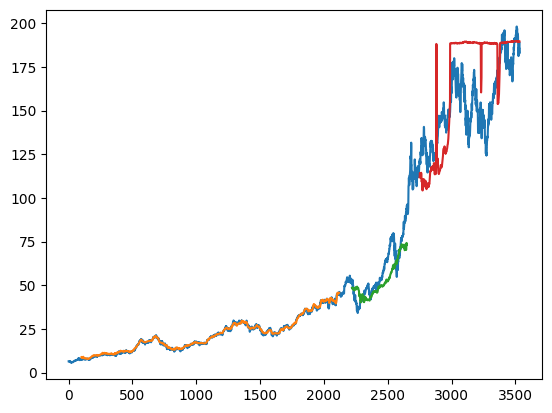

In [34]:
plt.plot(dataclose)

trainPredictPlot = np.empty_like(dataclose)
trainPredictPlot.fill(np.nan)
trainPredictPlot[timestep:len(train_predictraw)+timestep:] = train_predictraw
plt.plot(trainPredictPlot)

valPredictPlot = np.empty_like(dataclose)
valPredictPlot.fill(np.nan)
valPredictPlot[len(train_predictraw)+timestep*2:len(train_predictraw)+timestep*2+len(val_predictraw):] = val_predictraw
plt.plot(valPredictPlot)

testPredictPlot = np.empty_like(dataclose)
testPredictPlot.fill(np.nan)
testPredictPlot[len(train_predictraw)+timestep*3+len(val_predictraw):len(train_predictraw)+timestep*3+len(val_predictraw)+len(test_predictraw):] = test_predictraw
plt.plot(testPredictPlot)

plt.show()